In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    print("Agrego el src")

/home/alejandro/.dev/tda_2023Q1/tp2/src
Agrego el src


In [2]:
from data import generate_random_data
from bruteforce import pack, smartpack
from utils import perform_time_test

import matplotlib.pyplot as plt
import pandas as pd
import random
from collections.abc import Iterable
from multiprocessing import Pool

In [3]:
generate_random_data()

[0.69, 0.54, 0.76, 0.62, 0.4, 0.66, 0.3, 0.7, 0.66, 0.35]

In [39]:
def ratio_f(n, data):
    result_B, _ = perform_time_test(smartpack, data)
    result_A, _ = perform_time_test(pack, data)
    
    ratio = len(result_B)/len(result_A)
    if ratio > 1:
        pass
        #print(f"Encontre un dataset malo {ratio}, {data}")
    
    return n, len(result_A), len(result_B), ratio


def test_ratio(nsets: Iterable[float], pool_size=1):
    ns = []
    approximate_results = []
    new_results = []
    ratio_results = []

    async_responses = []
    
    with Pool(pool_size) as p:
        for data in nsets:
            nlen = len(data)
            #print(f'Llamo con {nlen} y {data}')
            async_res = p.apply_async(ratio_f, args=(nlen, data))
            #print(f'Obtuve como resultado de {nlen} en {exe_time}')
            async_responses.append(async_res)
            #time_results.append(exe_time)
            #ns.append(nlen)

        for async_res in async_responses:
            try:
                async_res.wait()
                n, result_approx, result_new, ratio = async_res.get()
                ns.append(n)
                approximate_results.append(result_approx)
                new_results.append(result_new)
                ratio_results.append(ratio)
            except KeyboardInterrupt:
                print("Exiting at client will")
                pass

    df = pd.DataFrame({'n': ns, 'approx': approximate_results, 'new_approx': new_results, 'ratio': ratio_results})
    return df

In [5]:
df_accum = None

In [20]:
%%time
min_n = 6
max_n = 1000
total_tests = 100000

testdata = (generate_random_data(length=random.randint(min_n, max_n)) for i in range(total_tests))
#list(testdata)
    
df_test = test_ratio(nsets=testdata, pool_size=4)
if df_accum is None:
    df_accum = df_test
else:
    df_accum = pd.concat([df_accum, df_test])
#df_test

Encontre un dataset choto 1.2, [0.71, 0.19, 0.27, 0.44, 0.25, 0.59, 0.36, 0.22, 0.12, 0.58, 0.8]
CPU times: user 1min, sys: 11.4 s, total: 1min 11s
Wall time: 1min 15s


In [21]:
len(df_accum)

400000

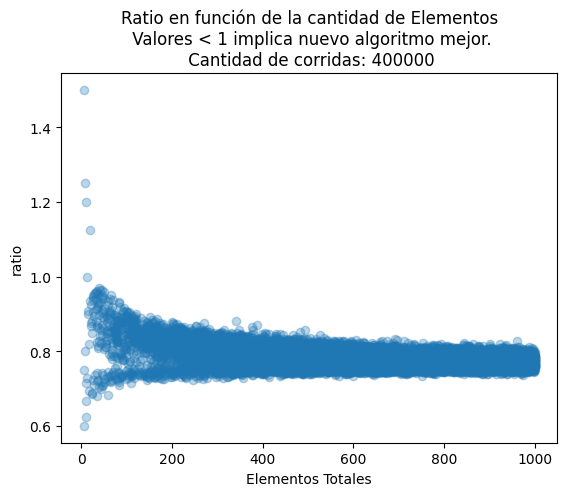

In [22]:
df_graf = df_accum.drop_duplicates(subset=['ratio'])
plt.scatter(df_graf['n'], df_graf['ratio'], alpha=0.3)
#plt.ylim(0, 3)
plt.xlabel("Elementos Totales")
plt.ylabel("ratio")
plt.title(f"Ratio en función de la cantidad de Elementos\n Valores < 1 implica nuevo algoritmo mejor.\n Cantidad de corridas: {len(df_accum)}")
plt.show()

In [23]:
total_elements = len(df_accum)
grouping = {
    'r<0.5': (df_accum['ratio'] < 0.5).sum(),
    '0.5<= r < 1': ((df_accum['ratio'] >= 0.5) & (df_accum['ratio'] < 1)).sum(),
    'r==1': (df_accum['ratio'] == 1).sum(),
    '1< r <= 1.5': ((df_accum['ratio'] > 1) & (df_accum['ratio']<= 1.5)).sum(),
    '1.5 < r <= 2': ((df_accum['ratio'] > 1.5) & (df_accum['ratio'] <=2 )).sum()
}
grouping

{'r<0.5': 0,
 '0.5<= r < 1': 398526,
 'r==1': 1468,
 '1< r <= 1.5': 6,
 '1.5 < r <= 2': 0}

In [25]:
ratio_g_keys = []
ratio_g_counts = []
ratio_g_percs = []

for key, counts in grouping.items():
    ratio_g_keys.append(key)
    ratio_g_counts.append(counts)
    ratio_g_percs.append(counts/total_elements)

df_ratios = pd.DataFrame({'group': ratio_g_keys, 'count': ratio_g_counts, 'perc': ratio_g_percs})
df_ratios

,group,count,perc
0,r<0.5,0,0.000000
1,0.5<= r < 1,398526,0.996315
2,r==1,1468,0.003670
3,1< r <= 1.5,6,0.000015
4,1.5 < r <= 2,0,0.000000


In [29]:
print(df_ratios.to_latex(index=False, column_format='|c|c|c|'))

\begin{tabular}{|c|c|c|}
\toprule
group & count & perc \\
\midrule
r<0.5 & 0 & 0.000000 \\
0.5<= r < 1 & 398526 & 0.996315 \\
r==1 & 1468 & 0.003670 \\
1< r <= 1.5 & 6 & 0.000015 \\
1.5 < r <= 2 & 0 & 0.000000 \\
\bottomrule
\end{tabular}



In [36]:
ranges_df = df_accum.groupby(pd.cut(df_accum['n'], [0, 200, 400, 600, 800, 1000])).count()
print(ranges_df.to_latex(index=True, columns=['n'], column_format='|c|c|'))
ranges_df

\begin{tabular}{|c|c|}
\toprule
 & n \\
n &  \\
\midrule
(0, 200] & 78658 \\
(200, 400] & 80119 \\
(400, 600] & 80753 \\
(600, 800] & 80484 \\
(800, 1000] & 79986 \\
\bottomrule
\end{tabular}



,n,approx,new_approx,ratio
n,,,,
"(0, 200]",78658,78658,78658,78658
"(200, 400]",80119,80119,80119,80119
"(400, 600]",80753,80753,80753,80753
"(600, 800]",80484,80484,80484,80484
"(800, 1000]",79986,79986,79986,79986


## Test of lower ranges

In [37]:
df_lower = None

In [40]:
%%time

testdata = (generate_random_data(length=random.randint(3, 10)) for i in range(100000))
#list(testdata)
    
df_test = test_ratio(nsets=testdata, pool_size=4)
if df_accum is None:
    df_lower = df_test
else:
    df_lower = pd.concat([df_lower, df_test])

CPU times: user 7.13 s, sys: 2.52 s, total: 9.65 s
Wall time: 7.19 s


In [41]:
len(df_lower)

200000

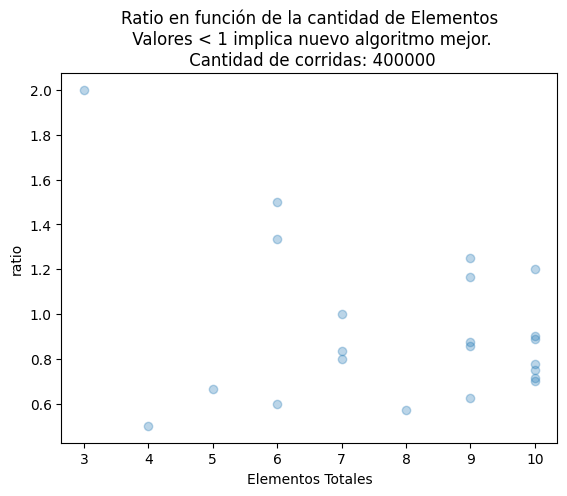

In [44]:
df_graf_lower = df_lower.drop_duplicates(subset=['ratio'])
plt.scatter(df_graf_lower['n'], df_graf_lower['ratio'], alpha=0.3)
#plt.ylim(0, 1)
plt.xlabel("Elementos Totales")
plt.ylabel("ratio")
plt.title(f"Ratio en función de la cantidad de Elementos\n Valores < 1 implica nuevo algoritmo mejor.\n Cantidad de corridas: {len(df_accum)}")
plt.show()